In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt

#style_transfer_url = "https://i.imgur.com/9ooB60I.jpg"
#base_url = "https://tourism.euskadi.eus/contenidos/d_destinos_turisticos/0000004981_d2_rec_turismo/en_4981/images/CT_cabecerabilbaoguggen.jpg"

#Picasso
#style_transfer_url = "https://1819class.weebly.com/uploads/1/4/9/7/1497362/published/985068164_2.jpg"

#Scream 
#style_transfer_url = "https://media.npr.org/assets/img/2012/04/30/scream_custom-9ef574d2014bd441879317ecf242ad060e34e743-s600-c85.webp"

style_transfer_url = "https://i.pinimg.com/564x/1b/0f/6f/1b0f6fd7b41751ffe4fec5480204d5d5.jpg"
#base_url = "https://cpb-us-w2.wpmucdn.com/people.smu.edu/dist/3/1170/files/2019/04/Diego-17vosgw.png"
base_url = "https://i.postimg.cc/RF8d85QX/005285.jpg"
#base_url = "https://0.academia-photos.com/40523139/11406763/12723363/s200_diego.klabjan.jpg"

style_image_path = get_file(fname = "style_art_Picture_.jpg", origin = style_transfer_url)
base_image_path = get_file(fname = "trng_img_picture_.jpg", origin = base_url)

16384/8123 [============================================================] - 0s 0us/step


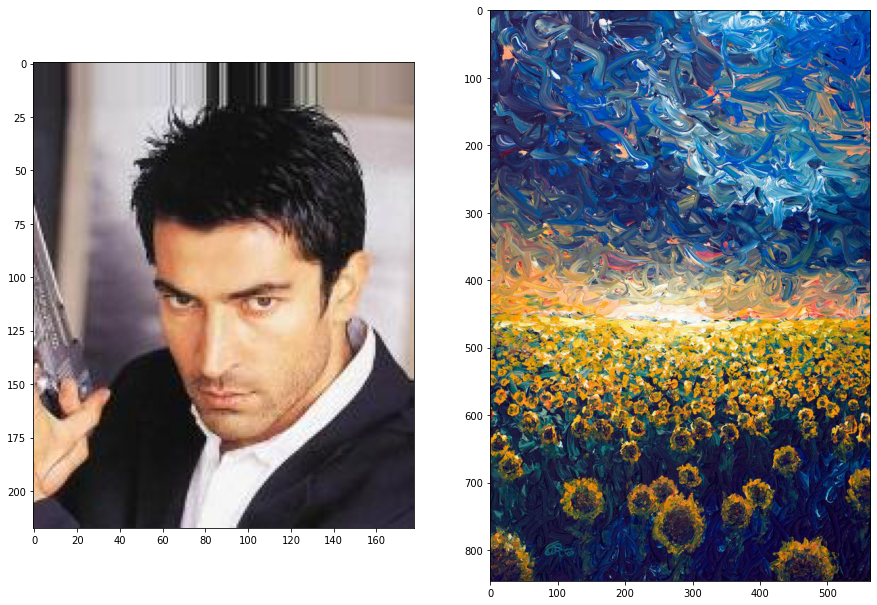

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# read the image file in a numpy array
a = plt.imread(base_image_path,0)
b = plt.imread(style_image_path,0)
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(a)
axarr[1].imshow(b)
plt.show()

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [ ]:
# Renaming --> number 1
def loss_style(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
# Renaming --> number 2
def loss_content(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import plot_model

#We can change the dataset for training (and obtain different models)
model = vgg16.VGG16(weights = "imagenet", include_top=False)

model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
from keras import Model

#Dictionary containing different layers in the architecture of VGG19
outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
# Renaming --> number 3
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Renaming --> number 4
content_layer = "block5_conv2"

# Looks arbitrary (may be helpful to play around with)
content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensor.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images
    features = feature_extractor(input_tensor)

    #3. Initialize the loss 
    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[content_layer]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * loss_content(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = loss_style(style_reference_features, combination_features)
        loss += (style_weight / len(style_layers)) * sl

    return loss

In [ ]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
import keras
from tensorflow.keras.applications import vgg19
import numpy as np


def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


In [ ]:
def deprocess_image(x):

    # We convert the tensor to Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # We make them have no average 0 (constants obtained from ImageNet presets)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # We convert from BGR to RGB.
    x = x[:, :, ::-1]

    # We make sure they are between 0 and 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [ ]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

In [ ]:
from tensorflow.keras.optimizers import SGD

width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

#Hyperparameter specifications
optimizer = SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 5000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 10: loss=20921.99
Iteration 20: loss=7702.63
Iteration 30: loss=5174.32
Iteration 40: loss=4036.98
Iteration 50: loss=3388.62
Iteration 60: loss=2971.04
Iteration 70: loss=2679.80
Iteration 80: loss=2463.05
Iteration 90: loss=2293.57
Iteration 100: loss=2156.21
Iteration 110: loss=2041.39
Iteration 120: loss=1942.95
Iteration 130: loss=1857.06
Iteration 140: loss=1780.85
Iteration 150: loss=1712.49
Iteration 160: loss=1650.55
Iteration 170: loss=1593.91
Iteration 180: loss=1541.81
Iteration 190: loss=1493.70
Iteration 200: loss=1449.11
Iteration 210: loss=1407.48
Iteration 220: loss=1368.55
Iteration 230: loss=1332.01
Iteration 240: loss=1297.68
Iteration 250: loss=1265.33
Iteration 260: loss=1234.80
Iteration 270: loss=1205.93
Iteration 280: loss=1178.57
Iteration 290: loss=1152.60
Iteration 300: loss=1127.92
Iteration 310: loss=1104.41
Iteration 320: loss=1081.98
Iteration 330: loss=1060.56
Iteration 340: loss=1040.10
Iteration 350: loss=1020.54
Iteration 360: loss=1001.81


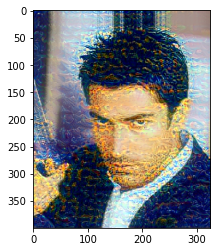

In [ ]:
plt.imshow(deprocess_image(np.array(combination_image)))